# Misura di plateau di efficienza

Questo codice genera un campione di particelle e la risposta di un ipotetico trigger che ha un'efficienza a soglia.

In [1]:
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt
import math

Assumiamo una distribuzione di una variabile $x$, che potrebbe rappresentare l'energia o il momento di un campione di particelle. Prendiamo una distribuzione gamma.

In [2]:
pdf = gamma(3, scale=10)

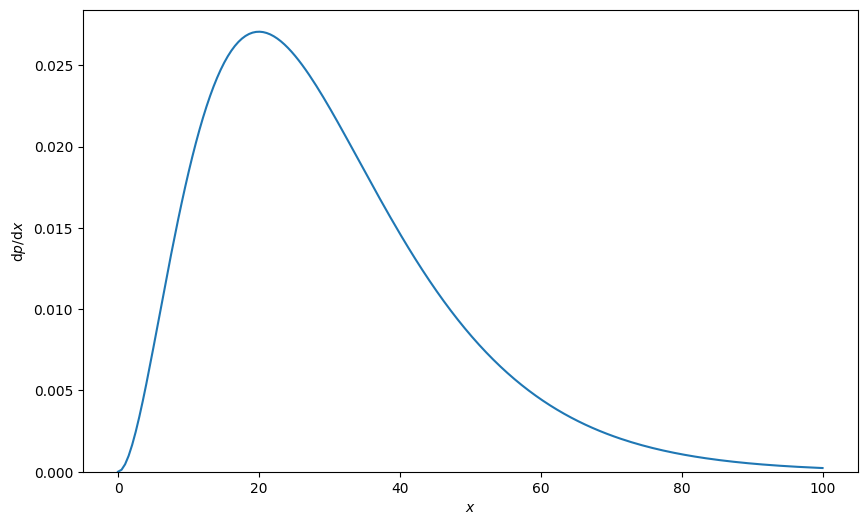

In [3]:
plt.figure(figsize=(10, 6))
xs = np.linspace(0,100,200)
ys = pdf.pdf(xs)
plt.plot(xs, ys)
plt.ylim(0)
plt.xlabel('$x$')
plt.ylabel('$\mathrm{d}p/\mathrm{d}x$')
plt.show()

Assumiamo che un sistema di rivelazione/identificazione delle particelle, che chiamiamo *trigger*, abbia un'efficienza $\varepsilon$ che cresca secondo una funzione a gradino, che modellizzeremo come una funzione logistica definita come:

$\displaystyle \varepsilon(x) = \frac{\varepsilon_0}{1+e^{-k(x-x_0)}}$

dove il valore asintotico $\varepsilon_0$, l'*efficienza di plateu*, è il nostro *parametro di interesse*, mentre $k$ e $x_0$ sono altri due parametri liberi.

In [4]:
def eff(x):
    return 0.96/(1 + np.exp(-0.3*(x - 20)))

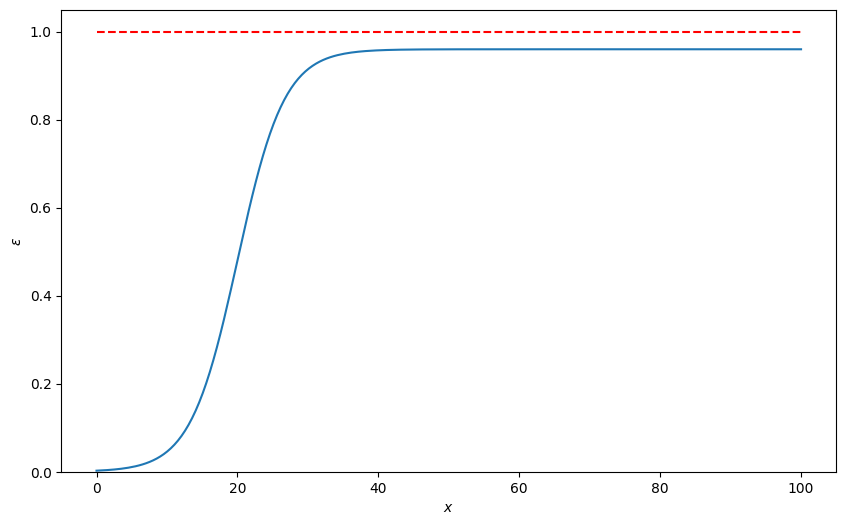

In [5]:
plt.figure(figsize=(10,6), dpi=100)
xs = np.linspace(0,100,200)
ys = eff(xs)
plt.plot(xs, ys)
plt.plot([0,100], [1,1], color='r', linestyle='--')
plt.ylim(0)
plt.xlabel('$x$')
plt.ylabel(r'$\varepsilon$')
plt.show()

Generiamo un campione casuale di valori di $x$ distribuiti secondo la distribuzione gamma, e per ciascuno determinamo casualmente se sia selezionato o meno dal trigger secondo l'efficienza $\varepsilon(x)$ che segue il modello logistico definito sopra.

In [6]:
x_sample = pdf.rvs(size=10000)

In [7]:
hit_sample = [np.random.random() < eff(x) for x in x_sample]

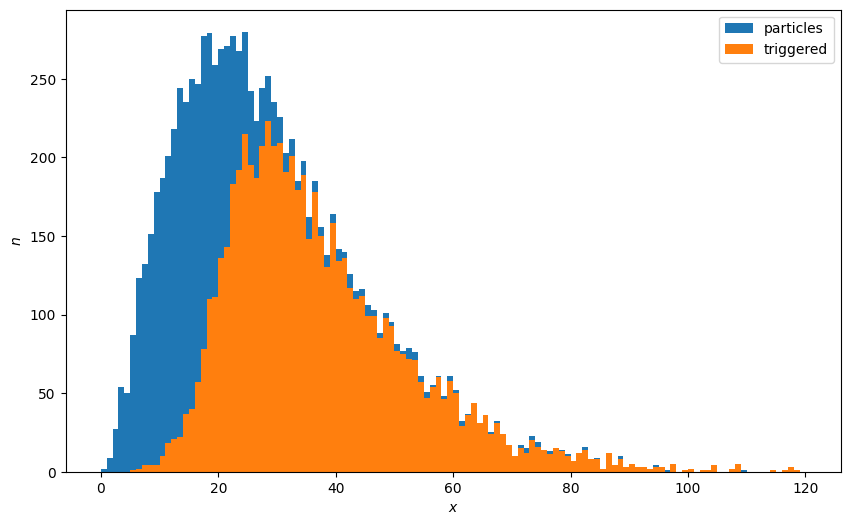

In [8]:
plt.figure(figsize=(10,6), dpi=100)
n_x, bins_x, patches_x = plt.hist(x_sample, label='particles', bins=120, range=(0,120))
n_h, bins_h, patches_h = plt.hist(x_sample[hit_sample], label='triggered', bins=120, range=(0,120))
plt.xlabel('$x$')
plt.ylabel('$n$')
plt.legend()
plt.show()

La stima dell'efficienza, per ciascun bin dei due istogrammi che abbiamo ottenuto, è data dal rapporto bin per bin degll'istogramma delle particelle selezionate rispetto a quello di tutte le particelle.

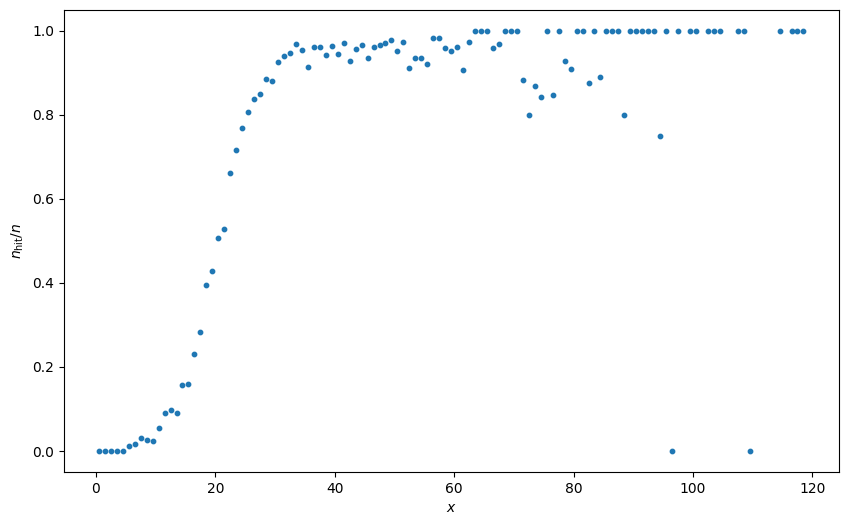

In [9]:
plt.figure(figsize=(10,6), dpi=100)
x_data = bins_x[:-1] + (bins_x[1] - bins_x[0])/2
#y_data = n_h/n_x
y_data = np.divide(n_h, n_x, out=np.zeros_like(n_x), where=n_x != 0)
plt.scatter(x_data[n_x>0], y_data[n_x>0], s=10)
plt.xlabel('$x$')
plt.ylabel('$n_{\mathrm{hit}}/n$')
plt.show()

Il campione viene esportato per essere utilizzato nell'esercizio seguente, che può essere svolto anche su un campione di dati reali, del quale però non conosceremo il vero andamento dell'efficienza in funzione di $x$.

In [10]:
import pandas as pd
data = {'x': x_sample, 'hit': hit_sample}
df = pd.DataFrame(data=data)

In [11]:
df.to_csv('output/trigger.csv')

# Esercizio

A partire da questi dati, misuerare l'andamento dell'efficienza in funzione di $x$ ed in particolare determinare l'efficienza di *plateau* (ossia: asintotica).

## Approssimazione gaussiana

In approssimazione gaussiana, possiamo fare un fit di minimo $\chi^2$ all'istogramma delle efficienze stimate:

$\displaystyle \hat{\varepsilon}_i = \frac{n_i}{N_i}$

La stima degli errori su può fare approssimando la deviazine standard della distribuzione binomiale, che non conosciamo, con la stima della deviazione standard $\hat{\varepsilon}_i$:


$\displaystyle \sigma_{\hat{\varepsilon}_i} = \sqrt{\frac{\hat{\varepsilon}_i(1-\hat{\varepsilon}_i)}{N_i}}$

Questa approssimazione diventa patologica per $n_i=0$ e $n_i=N_i$, ossia per $\hat{\varepsilon}_i=0$ e $\hat{\varepsilon}_i=1$, oltre che naturalmente per $N_i=0$.

Dovremo scartare tutti i bin per i quali $N_i=0$ oppure $\sigma_{\hat{\varepsilon}_i}=0$.

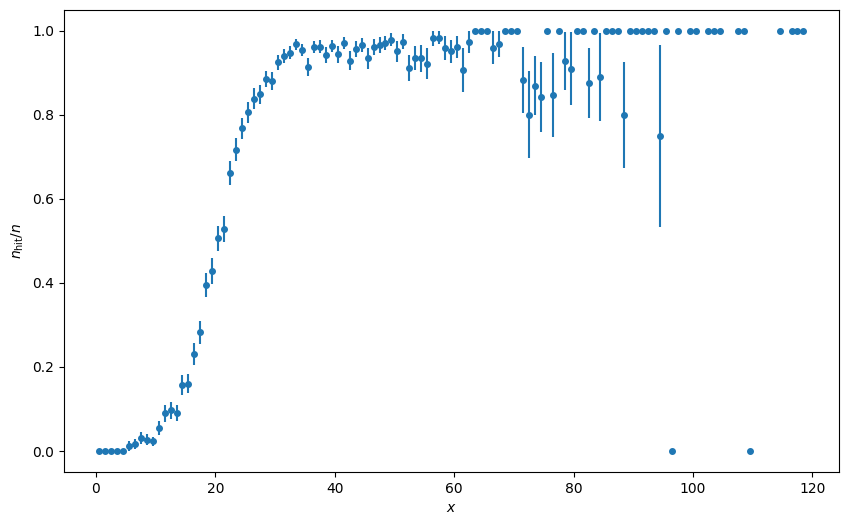

In [12]:
y_err = np.sqrt(np.divide(y_data*(1-y_data), n_x, out=np.zeros_like(n_x), where=n_x!=0))
plt.figure(figsize=(10,6), dpi=100)
plt.errorbar(x_data[n_x>0], y_data[n_x>0], yerr=y_err[n_x>0], fmt="o", markersize=4)
plt.xlabel('$x$')
plt.ylabel('$n_{\mathrm{hit}}/n$')
plt.show()

In [13]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
def model(x, epsilon, a, x0):
    return epsilon/(1.0 + np.exp(-a*(x - x0)))

In [14]:
least_squares_mode = LeastSquares(x_data[y_err>0], y_data[y_err>0], y_err[y_err>0], model)
m = Minuit(least_squares_mode, *(1, 0.1, 20), name=(r"$\varepsilon$", "$a$", "$x_0$"))
m.limits=((0,1), (0,100), (0, 100))

In [15]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 52.42 (χ²/ndof = 0.8)      │              Nfcn = 145              │
│ EDM = 5.2e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ 𝜀    │  0.9618   │  0.0034   │            │            │    0    │    1    │       │
│ 1 │ 𝑎    │   0.306   │   0.009   │            │            │    0    │   100   │       │
│ 2 │ 𝑥₀   │   20.22   │   0.13    │            │            │    0    │   100   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────┐
│    │         𝜀         𝑎        𝑥₀ │
├────┼───────────────────────────────┤
│  𝜀 │  1.19e-05 -0.011e-3  0.157e-3 │
│  𝑎 │ -0.011e-3  7.43e-05  -0.21e-3 │
│ 𝑥₀ │  0.157e-3  -0.21e-3    0.0171 │
└────┴───────────────────────────────┘

In [16]:
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 52.42 (χ²/ndof = 0.8)      │              Nfcn = 283              │
│ EDM = 5.2e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ 𝜀    │  0.9618   │  0.0035   │  -0.0034   │   0.0035   │    0    │    1    │       │
│ 1 │ 𝑎    │   0.306   │   0.009   │   -0.008   │   0.009    │    0    │   100   │       │
│ 2 │ 𝑥₀   │   20.22   │   0.13    │   -0.13    │    0.13    │    0    │   100   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │           𝜀           │           𝑎           │          𝑥₀           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.0034  │  0.0035   │  -0.008   │   0.009   │   -0.13   │   0.13    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────┬───────────────────────────────┐
│    │         𝜀         𝑎        𝑥₀ │
├────┼───────────────────────────────┤
│  𝜀 │  1.19e-05 -0.011e-3  0.157e-3 │
│  𝑎 │ -0.011e-3  7.43e-05  -0.21e-3 │
│ 𝑥₀ │  0.157e-3  -0.21e-3    0.0171 │
└────┴───────────────────────────────┘

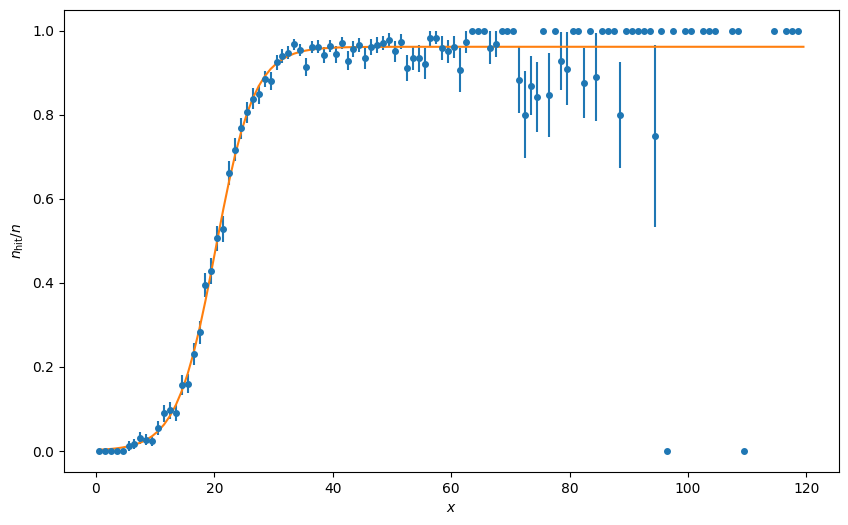

In [17]:
plt.figure(figsize=(10,6), dpi=100)
plt.errorbar(x_data[n_x>0], y_data[n_x>0], yerr=y_err[n_x>0], fmt="o", markersize=4)
plt.plot(x_data, model(x_data, *m.values))
plt.xlabel('$x$')
plt.ylabel('$n_{\mathrm{hit}}/n$')
plt.show()

## Fit di massima verosimiglianza binomiale

Se non vogliamo usare l'approssimazione gaussiana, che ci costringe a non usare i bin per i quali $n_i=0$ oppure $n_i=N_i$, possiamo usare una funzione di verosimiglianza ${\cal L}$ definita come il prodotto di tante probabilità binomiali quanti sono i bin:

$\displaystyle {\cal L}(n_i; N_i, \varepsilon_0, k, x_0) = \prod_{i=1}^b {\cal B}\left(n_i; N_i, \varepsilon(x_i; \varepsilon_0, k, x_0)\right)$

Sarà conveniente minimizzare l'opposto della somma dei logaritmi:

$\displaystyle -\log{\cal L}(n_i; N_i, \varepsilon_0, k, x_0) = -\sum_{i=1}^b \log{\cal B}\left(n_i; N_i, \varepsilon(x_i; \varepsilon_0, k, x_0)\right)$

Qui dovremo scartare solo i bin che hanno $N_i=0$, che comunque non contengono alcuna informazione.

La libreria ```binom``` ha una funzione che calcola direttamente il logaritmo di ${\cal B}$.

<span style="color:red">Attenzione: nel fit sarà necessario vincolare $\varepsilon_0$ tra 0 e 1 altrimenti, senza un'adeguata protezione numerica, il calcolo potebbe andare in *crash*.</span>

In [18]:
from scipy.stats import binom
def nl_like(*par):
    nl = 0
    for x, h, n in zip(x_data, n_h, n_x):
        if n>0:
            eff = model(x, *par) # par[0]/(1.0+np.exp(-par[1]*(x-par[2])))
            nl -= binom.logpmf(h, n, eff)
    return nl
nl_like.errordef = Minuit.LIKELIHOOD 
m_b = Minuit(nl_like, *(1, 0.1, 20), name=(r"$\varepsilon$", "$a$", "$x_0$"))
m_b.limits=((0,1), (0,100), (0, 100))
m_b.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 182.8                      │              Nfcn = 89               │
│ EDM = 5.76e-05 (Goal: 0.0001)    │            time = 2.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ 𝜀    │  0.9557   │  0.0035   │            │            │    0    │    1    │       │
│ 1 │ 𝑎    │   0.307   │   0.008   │            │            │    0    │   100   │       │
│ 2 │ 𝑥₀   │   20.14   │   0.13    │            │            │    0    │   100   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────┐
│    │         𝜀         𝑎        𝑥₀ │
├────┼───────────────────────────────┤
│  𝜀 │  1.21e-05 -0.010e-3  0.154e-3 │
│  𝑎 │ -0.010e-3  7.23e-05  -0.20e-3 │
│ 𝑥₀ │  0.154e-3  -0.20e-3    0.0173 │
└────┴───────────────────────────────┘

In [19]:
m_b.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 182.8                      │              Nfcn = 189              │
│ EDM = 5.76e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ 𝜀    │  0.9557   │  0.0035   │  -0.0036   │   0.0034   │    0    │    1    │       │
│ 1 │ 𝑎    │   0.307   │   0.009   │   -0.008   │   0.009    │    0    │   100   │       │
│ 2 │ 𝑥₀   │   20.14   │   0.13    │   -0.13    │    0.13    │    0    │   100   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │           𝜀           │           𝑎           │          𝑥₀           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.0036  │  0.0034   │  -0.008   │   0.009   │   -0.13   │   0.13    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────┬───────────────────────────────┐
│    │         𝜀         𝑎        𝑥₀ │
├────┼───────────────────────────────┤
│  𝜀 │  1.21e-05 -0.010e-3  0.154e-3 │
│  𝑎 │ -0.010e-3  7.23e-05  -0.20e-3 │
│ 𝑥₀ │  0.154e-3  -0.20e-3    0.0173 │
└────┴───────────────────────────────┘

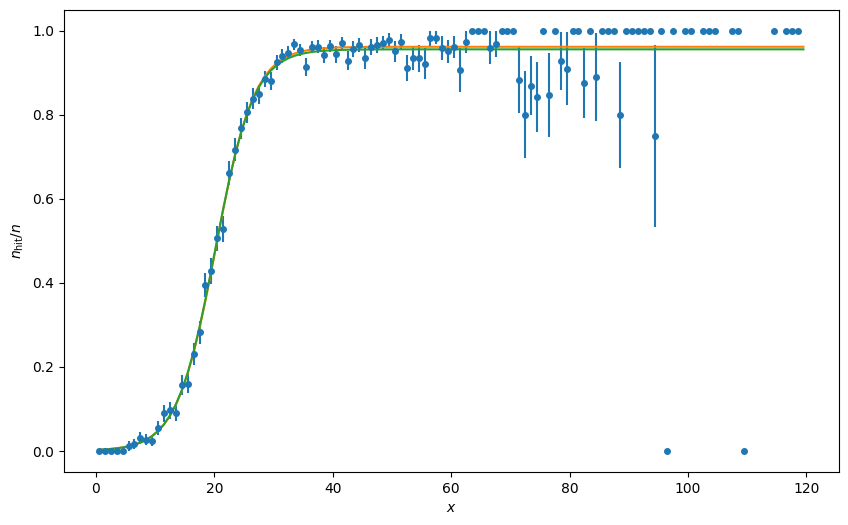

In [20]:
y_err = np.sqrt(np.divide(y_data*(1-y_data), n_x, out=np.zeros_like(n_x), where=n_x!=0))
plt.figure(figsize=(10,6), dpi=100)
plt.errorbar(x_data[n_x>0], y_data[n_x>0], yerr=y_err[n_x>0], fmt="o", markersize=4)
plt.plot(x_data, model(x_data, *m.values))
plt.plot(x_data, model(x_data, *m_b.values))
plt.xlabel('$x$')
plt.ylabel('$n_{\mathrm{hit}}/n$')
plt.show()

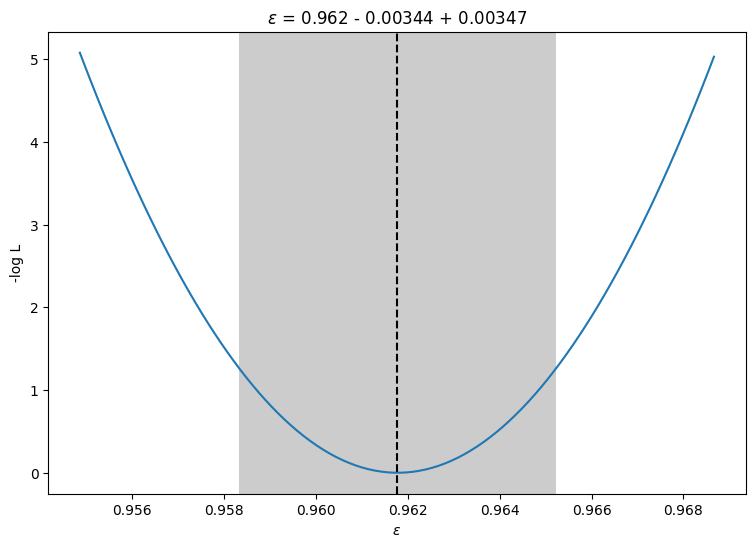

In [21]:
plt.figure(figsize=(9,6), dpi=100)
x, y = m.draw_profile(r"$\varepsilon$")
plt.ylabel('-log L')
plt.show()

## Applicazione a dati reali

I dati che seguno fanno parte di un set di open data dell'esperimento CMS.

Da notare che nei collider adronici si usa la *pseudorapidità* al posto dell'angolo polare, definita come:

$\displaystyle\eta = -\ln\left[\tan\left(\frac{\theta}{2}\right)\right]$

*Courtesy*: Alberto Orso Maria Iorio.

Determinare il plateau di efficienza di *trigger* nel campione selezionato.

In [22]:
df=pd.read_csv("data/DataMET.csv")

In [23]:
df

,Unnamed: 0,muon_eta,muon_id,muon_iso,muon_phi,muon_pt,passes_trigger
0,0,-1.364455,1.0,3.106402,0.551265,4.516479,0
1,1,-1.846408,0.0,0.000000,3.109039,1.036130,0
2,2,1.617842,0.0,12.674729,-2.806312,2.673130,0
3,3,-1.610999,0.0,24.143774,1.187441,1.211710,0
4,4,-0.630382,1.0,111.184525,3.015921,15.549014,0
...,...,...,...,...,...,...,...
118685,118685,-1.574887,1.0,5.327117,1.797181,3.440294,0
118686,118686,-2.405900,0.0,0.000000,2.199693,1.515344,0
118687,118687,-2.006377,0.0,0.000000,-2.438155,2.319732,0
118688,118688,-0.132713,0.0,0.000000,-3.135328,0.669478,0


<Axes: >

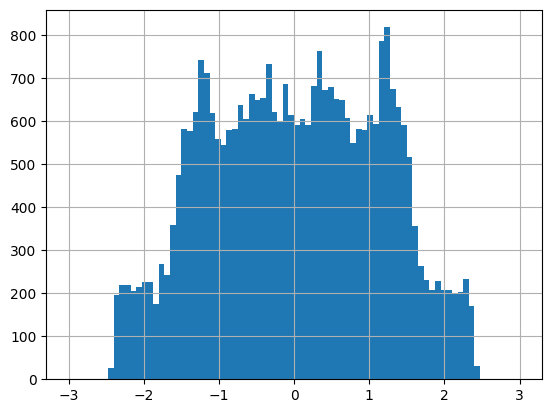

In [24]:
df[df.muon_id==1].muon_eta.hist(bins=80, range=(-3,3))

<Axes: >

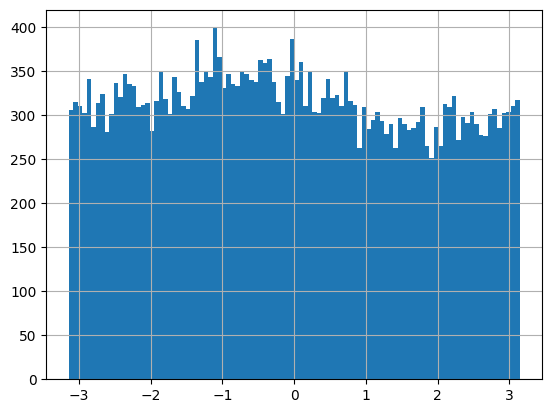

In [25]:
df[df.muon_id==1].muon_phi.hist(bins=100, range=(-math.pi,math.pi))

<Axes: >

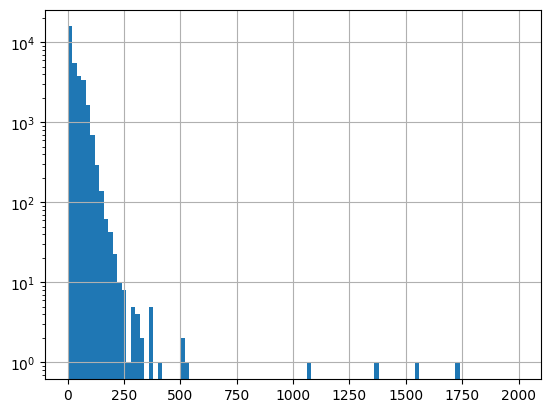

In [26]:
df[df.muon_id==1].muon_pt.hist(bins=100, range=(0,2000), log=True)

<Axes: >

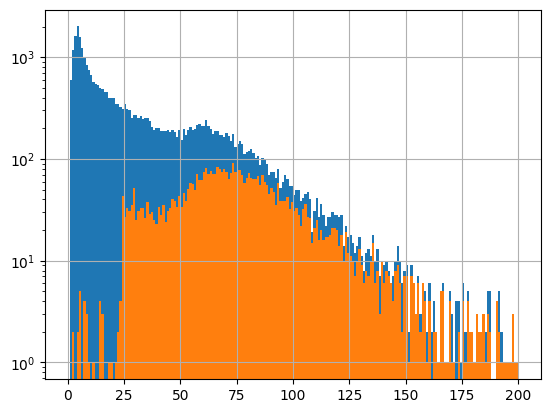

In [27]:
df[(df.muon_id==1) & (df.muon_pt<200)].muon_pt.hist(bins=200, range=(0,200), log=True)
df[(df.muon_id==1) & (df.muon_pt<200) & (df.passes_trigger==1)].muon_pt.hist(bins=200, range=(0,200), log=True)

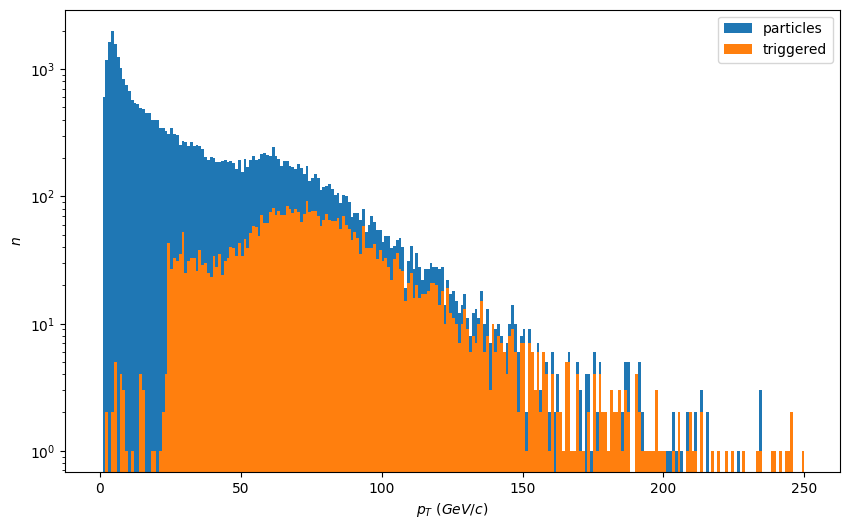

In [28]:
plt.figure(figsize=(10,6), dpi=100)
df_sel = df[(df.muon_id==1) & (df.muon_pt<250)]
bins, x_range = 250, (0, 250)
n_x, bins_x, patches_x = plt.hist(df_sel.muon_pt, label='particles', bins=bins, range=x_range)
n_h, bins_h, patches_h = plt.hist(df_sel[df_sel.passes_trigger==1].muon_pt, label='triggered',
                                bins=bins, range=x_range)
plt.xlabel('$p_T\ (GeV/c)$')
plt.ylabel('$n$')
plt.legend()
plt.yscale('log')
plt.show()

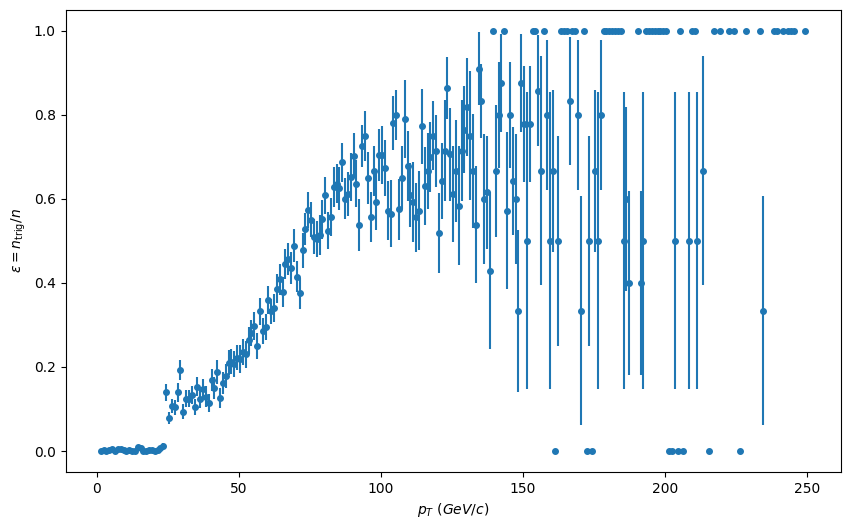

In [29]:
x_data = bins_x[:-1]+(bins_x[1]-bins_x[0])/2
y_data = np.divide(n_h, n_x, out=np.zeros_like(n_x), where=n_x!=0)
y_err = np.sqrt(np.divide(y_data*(1-y_data), n_x, out=np.zeros_like(n_x), where=n_x!=0))
plt.figure(figsize=(10,6), dpi=100)
plt.errorbar(x_data[n_x>0], y_data[n_x>0], yerr=y_err[n_x>0], fmt="o", markersize=4)
plt.xlabel('$p_T\ (GeV/c)$')
plt.ylabel(r'$\varepsilon = n_{\mathrm{trig}}/n$')
plt.show()

In [30]:
x_min = 25
def model_h(x, *par):
    return par[0]+(par[1] - par[0])/(1.0 + np.exp(-par[2]*(x - par[3])))
select = x_data>=x_min
x_data_select, n_h_select, n_x_select = x_data[select], n_h[select], n_x[select]
def nl_like(*par):
    nl = 0
    for x, h, n in zip(x_data_select, n_h_select, n_x_select):
        if n>0:
            eff = model_h(x, *par)
            nl -= binom.logpmf(h, n, eff)
    return nl
nl_like.errordef = Minuit.LIKELIHOOD 
m_t = Minuit(nl_like, *(0.088, 0.696, 0.086, 65.1), name=(r"$\varepsilon_0$", r"$\varepsilon$", "$a$", "$x_0$"))
m_t.limits=((0,1), (0,1), (0,100), (0, 100))
m_t.migrad()
m_t.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 412.6                      │              Nfcn = 365              │
│ EDM = 7.56e-06 (Goal: 0.0001)    │            time = 8.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ 𝜀₀   │   0.088   │   0.011   │   -0.012   │   0.010    │    0    │    1    │       │
│ 1 │ 𝜀    │   0.696   │   0.014   │   -0.014   │   0.014    │    0    │    1    │       │
│ 2 │ 𝑎    │   0.086   │   0.007   │   -0.007   │   0.007    │    0    │   100   │       │
│ 3 │ 𝑥₀   │   65.1    │    0.9    │    -0.9    │    0.9     │    0    │   100   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          𝜀₀           │           𝜀           │           𝑎           │          𝑥₀           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.012   │   0.010   │  -0.014   │   0.014   │  -0.007   │   0.007   │   -0.9    │    0.9    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────┬─────────────────────────────────────┐
│    │       𝜀₀        𝜀        𝑎       𝑥₀ │
├────┼─────────────────────────────────────┤
│ 𝜀₀ │ 0.000122 -0.06e-3  0.06e-3  2.96e-3 │
│  𝜀 │ -0.06e-3 0.000186 -0.06e-3  6.72e-3 │
│  𝑎 │  0.06e-3 -0.06e-3 4.56e-05 -0.56e-3 │
│ 𝑥₀ │  2.96e-3  6.72e-3 -0.56e-3     0.76 │
└────┴─────────────────────────────────────┘

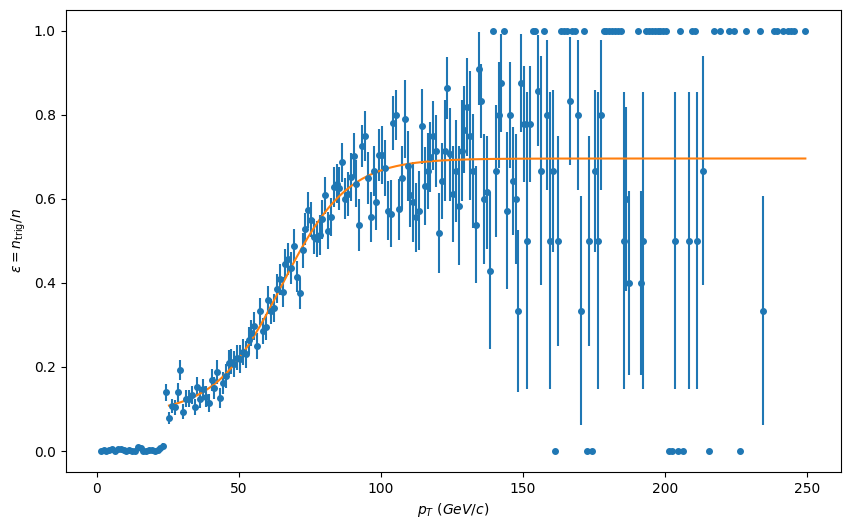

In [31]:
plt.figure(figsize=(10,6), dpi=100)
plt.errorbar(x_data[n_x>0], y_data[n_x>0], yerr=y_err[n_x>0], fmt="o", markersize=4)
plt.plot(x_data[x_data>=x_min], model_h(x_data[x_data>=x_min], *m_t.values))
plt.xlabel('$p_T\ (GeV/c)$')
plt.ylabel(r'$\varepsilon = n_{\mathrm{trig}}/n$')
plt.show()